In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig

D:\Anaconda\envs\llm-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
dataset_name = "financial_phrasebank"

dataset = load_dataset(dataset_name, "sentences_allagree")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [4]:
dataset['train'][0]['sentence']

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [5]:
for i in range(5):
    print(f"Sentence: {dataset['train'][i]['sentence']}")
    print(f"Label: {dataset['train'][i]['label']}")

Sentence: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Label: 1
Sentence: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Label: 2
Sentence: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
Label: 2
Sentence: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .
Label: 2
Sentence: Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .
Label: 2


In [6]:
labels_df = pd.DataFrame()

labels_from_dataset = [dataset['train'][i]['label'] for i in range(2264)]

labels_df['labels'] = labels_from_dataset
labels_df.head()

,labels
0,1
1,2
2,2
3,2
4,2


In [7]:
labels_df['labels'].value_counts()

labels
1    1391
2     570
0     303
Name: count, dtype: int64

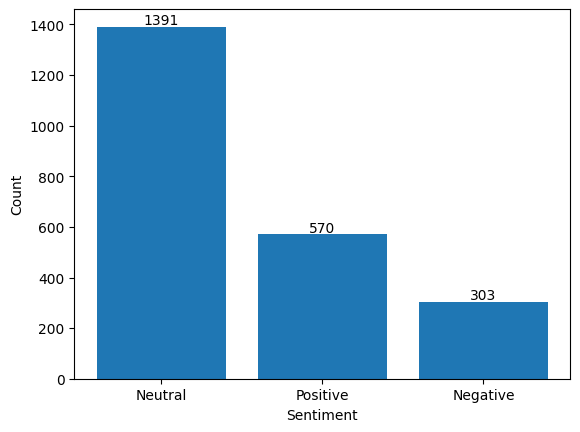

In [8]:
fig, ax = plt.subplots()

x = ['Neutral', 'Positive', 'Negative']
y = [1391, 570, 303]

ax.bar(x,y)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

for i, v in enumerate(y):
    plt.text(x=i, y=v+10, s=str(v), ha='center')

## Load model

In [10]:
model_name = "google/flan-t5-base"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [9]:
# test_sentences = [
#     "The Company posted quarterly revenue of $81.8 billion, down 1 percent year over year, and quarterly earnings per diluted share of $1.26, up 5 percent year over year.",
#     "We are happy to report that we had an all-time revenue record in Services during the June quarter, driven by over 1 billion paid subscriptions",
#     "Net sales were $1.237 billion for the period, compared to $1.378 billion in the prior year's first quarter.",
#     "At the start of 2021, GameStop had burdensome debt, dwindling cash, outdated systems and technology, and no meaningful stockholders in the boardroom"
# ]

### No prompt engineering

In [12]:
# for i in range(2264):
#     sentence = dataset['train'][i]['sentence']

#     inputs = tokenizer(sentence, return_tensors='pt')
#     output = tokenizer.decode(
#         model.generate(
#             inputs["input_ids"],
#             max_new_tokens=50
#         )[0],
#         skip_special_tokens=True
#     )

#     print(f"Sentence: {sentence}")
#     print(f"Model ouput: {output}")

### Zero-shot inference with prompt engineering

In [13]:
zero_shot_sentiment = []

for i in range(2264):
    sentence = dataset['train'][i]['sentence']

    prompt = f"""
Is the follwing sentence positive, negative or neutral?

{sentence}
    """

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50
        )[0],
        skip_special_tokens=True
    )

    zero_shot_sentiment.append(output)

zero_shot_sentiment[:5]

['negative', 'positive', 'positive', 'positive', 'positive']

In [15]:
labels_df['zero_shot_sentiment'] = zero_shot_sentiment
labels_df['zero_shot_sentiment'] = labels_df['zero_shot_sentiment'].map({'neutral':1, 'positive':2, 'negative':0})

labels_df.head()

,labels,zero_shot_sentiment
0,1,0
1,2,2
2,2,2
3,2,2
4,2,2


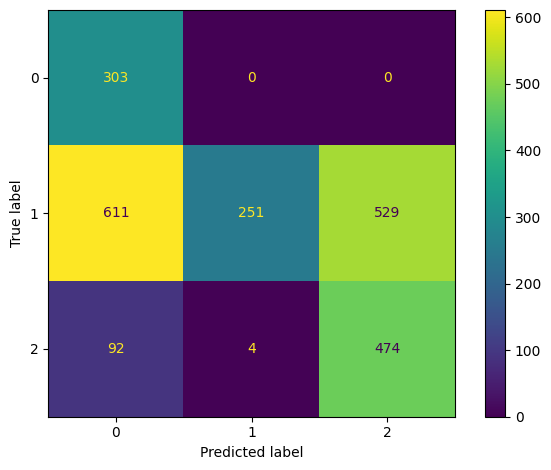

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels_df['labels'], labels_df['zero_shot_sentiment'], labels=[0,1,2])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

### One-shot inference

In [19]:
one_shot_sentiment = []

for i in range(2264):
    sentence = dataset['train'][i]['sentence']

    prompt = f"""

Is the follwing sentence positive, negative or neutral?

Statement: "According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
neutral

Is the follwing sentence positive, negative or neutral?
Statement: {sentence}

{sentence}
    """

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50
        )[0],
        skip_special_tokens=True
    )

    one_shot_sentiment.append(output)

one_shot_sentiment[:5]

['positive', 'positive', 'positive', 'positive', 'positive']

In [20]:
labels_df['one_shot_sentiment'] = one_shot_sentiment
labels_df['one_shot_sentiment'] = labels_df['one_shot_sentiment'].map({'neutral':1, 'positive':2, 'negative':0})

labels_df.head()

,labels,zero_shot_sentiment,one_shot_sentiment
0,1,0,2
1,2,2,2
2,2,2,2
3,2,2,2
4,2,2,2


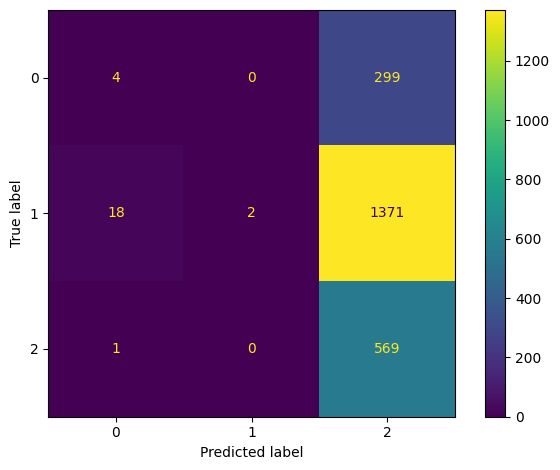

In [22]:
cm = confusion_matrix(labels_df['labels'], labels_df['one_shot_sentiment'], labels=[0,1,2])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()